In [6]:
# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings('ignore')

In [7]:
#Let's first import required Python packages.
#Importing required Python packages
import matplotlib.pylab as plt
import numpy as np
from scipy import sparse
from sklearn.datasets import make_classification, make_blobs, load_boston
from sklearn.decomposition import PCA
from sklearn.cross_validation import ShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.learning_curve import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.grid_search import GridSearchCV
from pprint import pprint
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import urllib
import seaborn

np.random.seed(sum(map(ord, "aesthetics")))
seaborn.set_context('notebook')

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5) 

# Set some Pandas options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 25)
pd.options.display.max_colwidth = 50

%matplotlib inline

In [8]:
traincsv=pd.read_csv('train.csv', index_col='Id')
testcsv=pd.read_csv('test.csv', index_col='Id')

orig_traincsv = traincsv.copy()
orig_testcsv = testcsv.copy()

In [10]:
rf_initial = RandomForestClassifier(n_estimators = 1000, bootstrap = True, oob_score = True)
rf_initial.fit(traincsv.ix[:,:-1].values, traincsv.ix[:,-1:].values.ravel())
print "Initial Traincsv score: %.2f" %rf_initial.score(traincsv.ix[:,:-1].values, traincsv.ix[:,-1:].values.ravel())

Initial Traincsv score: 1.00


In [ ]:
#Make a copy of the test.csv file
temp=testcsv.copy()

#Run Predictions on test.csv
temp['Cover_Type']=rf_initial.predict(temp.values)

#Create Submissions csv file
temp=temp['Cover_Type']
temp.to_csv('RF-Initial.csv', header=True)

# The submission to Kaggle scored 0.75366, taking us to better than 50% of the leaderboard. 

In [11]:


#Always call fit on the estimator before invoking this method.
def importances(estimator, col_array, title):

# Calculate the feature ranking - Top 10
    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1] #It returns the indices that would sort an array.

    print "%s Top 20 Important Features\n" %title

    for f in range(20):
        print("%d. %s   (%f)" % (f + 1, col_array.columns[indices[f]], importances[indices[f]]))
    
#Mean Feature Importance
    print "\nMean Feature Importance %.6f" %np.mean(importances)
    
#Plot the feature importances of the forest
    indices=indices[:10]
    plt.figure()
    plt.title(title+" Top 10 Feature importances")
    plt.bar(range(10), importances[indices],
            color="gr", align="center")
    plt.xticks(range(10), col_array.columns[indices], fontsize=14, rotation=90)
    plt.xlim([-1, 10])
    plt.show()



Cover Type (Initial RF) Top 20 Important Features

1. Elevation   (0.224967)
2. Horizontal_Distance_To_Roadways   (0.092551)
3. Horizontal_Distance_To_Fire_Points   (0.073362)
4. Horizontal_Distance_To_Hydrology   (0.062791)
5. Vertical_Distance_To_Hydrology   (0.053563)
6. Hillshade_9am   (0.051268)
7. Aspect   (0.049895)
8. Hillshade_3pm   (0.045794)
9. Hillshade_Noon   (0.044669)
10. Wilderness_Area4   (0.044597)
11. Slope   (0.036121)
12. Soil_Type10   (0.022652)
13. Soil_Type38   (0.019792)
14. Soil_Type39   (0.018392)
15. Soil_Type3   (0.018368)
16. Wilderness_Area1   (0.017934)
17. Wilderness_Area3   (0.017270)
18. Soil_Type4   (0.012858)
19. Soil_Type40   (0.010416)
20. Soil_Type30   (0.007916)

Mean Feature Importance 0.018519


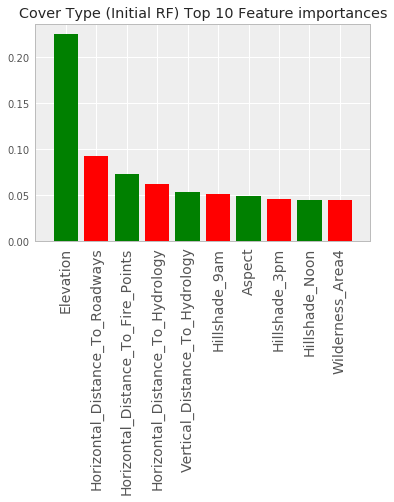

In [12]:
#Call the method we just created to display the feature importances
importances(rf_initial, traincsv, "Cover Type (Initial RF)")



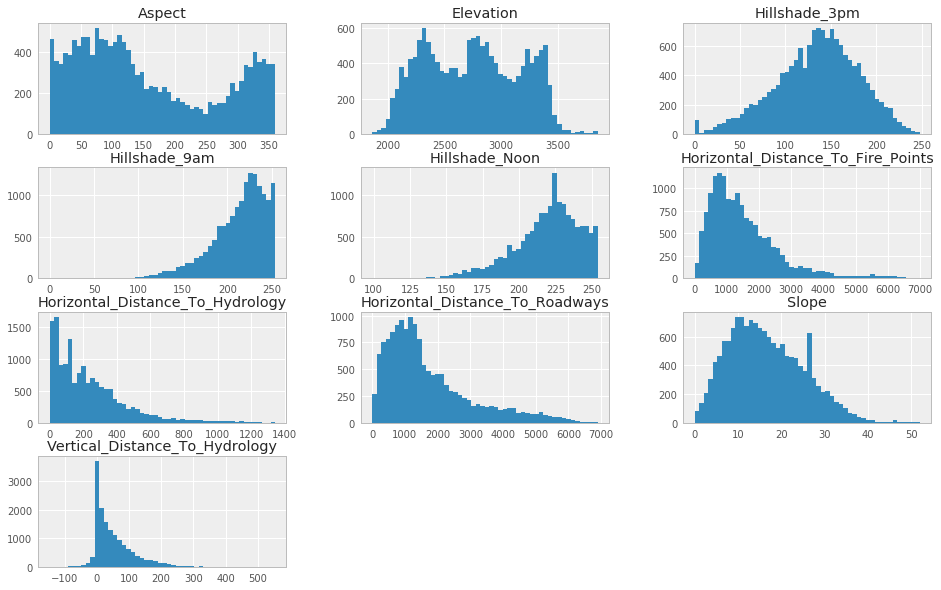

In [36]:
traincsv.ix[:,:10].hist(figsize=(16,10), bins=50)
plt.show()
#Looks like there're some missing values for Hillshade at 3 PM. 
#If there was shade at 9 AM, I'd expect little shade at 3 PM but 0 doesn't sit right. 
#We'll explore this further down the line, since Hillshade 3 PM is in the Top 10.



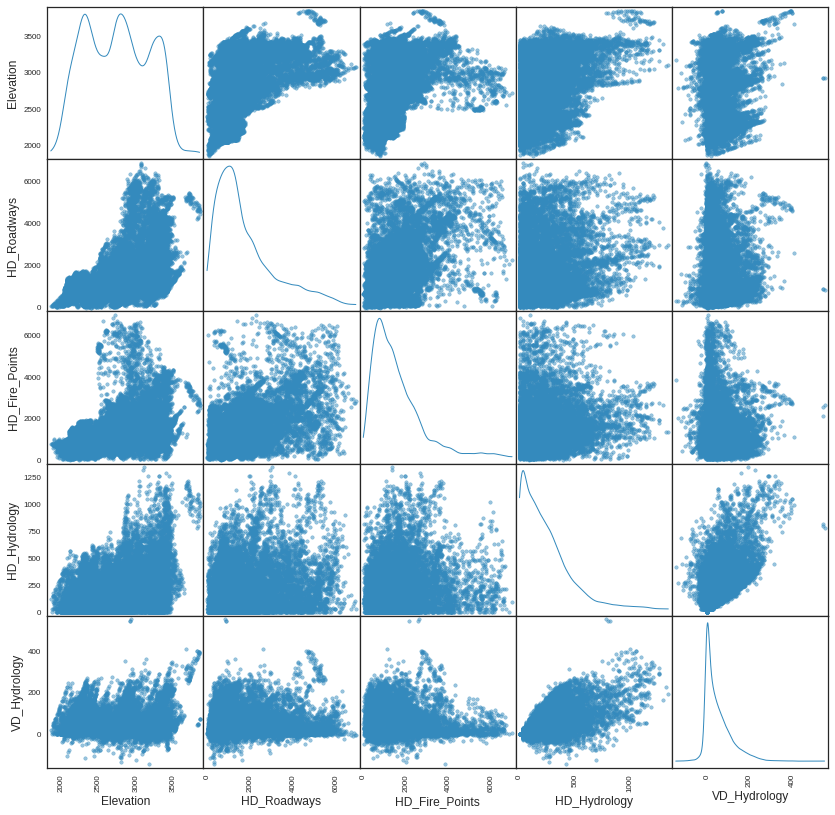

In [37]:
with seaborn.axes_style('white'): 
    smaller_frame=traincsv[['Elevation', 'Horizontal_Distance_To_Roadways', 
                            'Horizontal_Distance_To_Fire_Points', 
                            'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']]
    smaller_frame.columns=smaller_frame.columns.map(lambda x: x.replace('Horizontal_Distance_To','HD'))
    smaller_frame.columns=smaller_frame.columns.map(lambda x: x.replace('Vertical_Distance_To','VD'))
    scatter_matrix(smaller_frame, figsize=(14, 14), diagonal="kde") 
plt.show()

In [38]:
#Let's add Cover Type to smaller_frame so we can color code.
smaller_frame['Cover_Type']=traincsv.Cover_Type

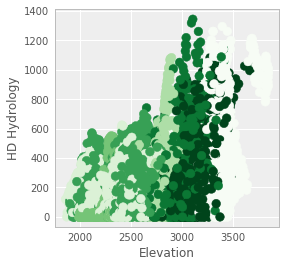

In [40]:
#Elevation vs HD Hydrology
plt.figure(figsize=(4,4))
plt.scatter(smaller_frame.Elevation, smaller_frame.HD_Hydrology, c=smaller_frame.Cover_Type, s=75, cmap=plt.cm.Greens_r)
plt.xlabel("Elevation")
plt.ylabel("HD Hydrology")
plt.show()

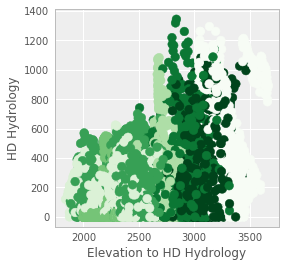

In [46]:
#Elevation adjusted vs HD Hydrology
plt.figure(figsize=(4,4))
plt.scatter(smaller_frame.Elevation-0.2*smaller_frame.HD_Hydrology, 
            smaller_frame.HD_Hydrology, c=smaller_frame.Cover_Type, s=75, cmap=plt.cm.Greens_r)
plt.xlabel("Elevation to HD Hydrology")
plt.ylabel("HD Hydrology")
plt.show()


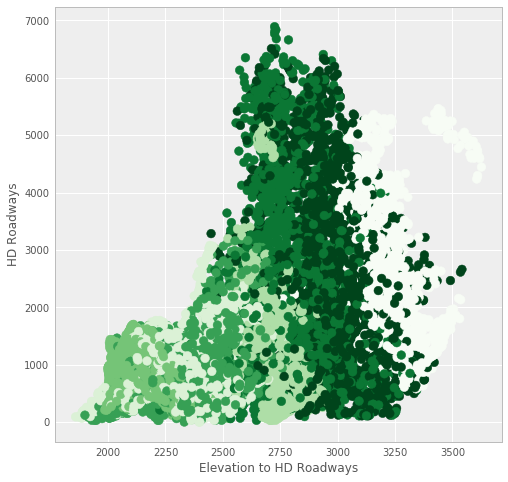

In [47]:
#Elevation vs HD Roadways
plt.figure(figsize=(8,8))
plt.scatter(smaller_frame.Elevation-0.05*smaller_frame.HD_Roadways, 
            smaller_frame.HD_Roadways, c=smaller_frame.Cover_Type, s=75, cmap=plt.cm.Greens_r)
plt.xlabel("Elevation to HD Roadways")
plt.ylabel("HD Roadways")
plt.show()

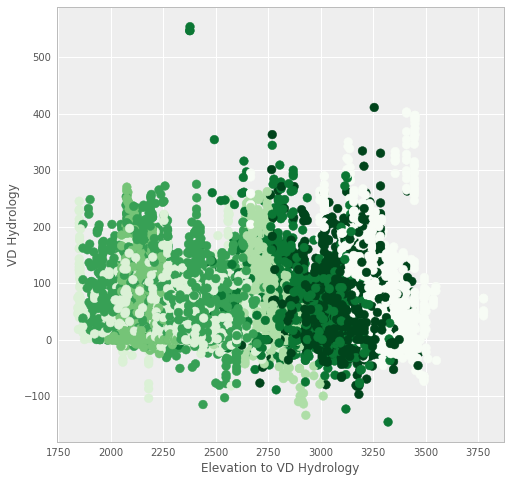

In [48]:


#Elevation vs VD Hyrdrology
plt.figure(figsize=(8,8))
plt.scatter(smaller_frame.Elevation-smaller_frame.VD_Hydrology, 
            smaller_frame.VD_Hydrology, c=smaller_frame.Cover_Type, s=75, cmap=plt.cm.Greens_r)
plt.xlabel("Elevation to VD Hydrology")
plt.ylabel("VD Hydrology")
plt.show()



In [53]:
temp=traincsv.copy()
cols=temp.columns.tolist()
cols=cols[:8]+cols[9:]+[cols[8]]
temp=temp[cols]
del temp['Cover_Type']

In [54]:
#Split the train.csv file into train (available values) and missing values based on hillshade 3 PM.
X,y,X_traincsv_missing,y_traincsv_missing= temp[temp.Hillshade_3pm!=0].values[:,:-1], \
                                           temp[temp.Hillshade_3pm!=0].values[:,-1:].ravel(), \
                                           temp[temp.Hillshade_3pm==0].values[:,:-1], \
                                           temp[temp.Hillshade_3pm==0].values[:,-1:].ravel()
            
#Let's very quickly do a train/cv split so we can see how the model will generalize. Note that we're calling this cv since 
#we're not going to be doing exhaustive cross-validation. We'll test performance using the cv set and predict on test. I am
#calling this cv so as to not confuse with terminology.
X_train,X_test,y_train,y_test=train_test_split(X,y)

In [55]:
#Fit a Gradient Boosted Regression Tree model to this dataset.
gbrt=GradientBoostingRegressor(n_estimators=1000)
gbrt.fit(X_train,y_train)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [56]:
print 'Training R-squared value: %.2f' %gbrt.score(X_train, y_train)
print 'Test R-squared value: %.2f' %gbrt.score(X_test, y_test)

Training R-squared value: 1.00
Test R-squared value: 1.00


Hillshade 3 PM Top 20 Important Features

1. Aspect   (0.266811)
2. Hillshade_9am   (0.216063)
3. Slope   (0.182738)
4. Hillshade_Noon   (0.163784)
5. Horizontal_Distance_To_Fire_Points   (0.034282)
6. Horizontal_Distance_To_Roadways   (0.034035)
7. Elevation   (0.031347)
8. Vertical_Distance_To_Hydrology   (0.025692)
9. Horizontal_Distance_To_Hydrology   (0.019742)
10. Soil_Type13   (0.002673)
11. Soil_Type1   (0.002460)
12. Soil_Type30   (0.002222)
13. Soil_Type3   (0.001699)
14. Soil_Type33   (0.001481)
15. Soil_Type4   (0.001412)
16. Soil_Type17   (0.001195)
17. Soil_Type27   (0.000932)
18. Soil_Type39   (0.000876)
19. Soil_Type24   (0.000830)
20. Soil_Type14   (0.000783)

Mean Feature Importance 0.018868


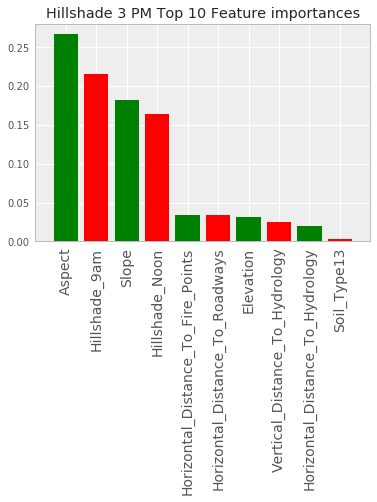

In [57]:
# Calculate the feature ranking - Top 10 
importances(gbrt, temp, "Hillshade 3 PM")


In [59]:
#Predict and fill missing values in train.csv 
temp.Hillshade_3pm.loc[temp.Hillshade_3pm==0]=gbrt.predict(X_traincsv_missing)
traincsv.Hillshade_3pm=temp.Hillshade_3pm


#Make a copy and Reorder test.csv columns
temp=testcsv.copy()
cols=temp.columns.tolist()
cols=cols[:8]+cols[9:]+[cols[8]]
temp=temp[cols]

#Extract missing rows from test.csv then predict and fill in the blanks.
X_testcsv_missing= temp[temp.Hillshade_3pm==0].values[:,:-1]
temp.Hillshade_3pm.loc[temp.Hillshade_3pm==0]=gbrt.predict(X_testcsv_missing)
testcsv.Hillshade_3pm=temp.Hillshade_3pm



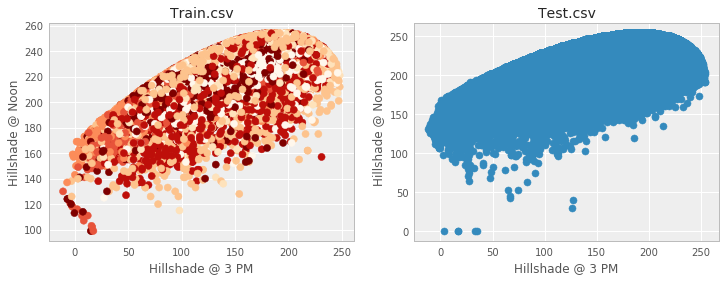

In [60]:
fig, ax=plt.subplots(1,2,figsize=(12,4)) 
ax[0].scatter(traincsv.Hillshade_3pm,traincsv.Hillshade_Noon, c=traincsv.Cover_Type, s=50, cmap=plt.cm.OrRd)
ax[0].set_xlabel('Hillshade @ 3 PM')
ax[0].set_ylabel('Hillshade @ Noon')
ax[0].set_title('Train.csv', fontsize=14)
ax[1].scatter(testcsv.Hillshade_3pm,testcsv.Hillshade_Noon, s=50, cmap=plt.cm.PuBu)
ax[1].set_xlabel('Hillshade @ 3 PM')
ax[1].set_ylabel('Hillshade @ Noon')
ax[1].set_title('Test.csv', fontsize=14)
plt.show()

In [64]:


#75/25 Split
X_train, X_test, y_train, y_test = train_test_split(traincsv.ix[:,:-1].values, traincsv.ix[:,-1:].values.ravel())
print X_train.shape, X_test.shape, y_train.shape, y_test.shape



(11340, 54) (3780, 54) (11340,) (3780,)


In [68]:
def CrossValidate(estimator, param_grid, n_jobs):

#Choose cross-validation generator - let's choose ShuffleSplit which randomly shuffles and selects Train and CV sets
#for each iteration. There are other methods like the KFold split.
    cv = ShuffleSplit(X_train.shape[0], n_iter=3, test_size=0.2)

#Apply the cross-validation iterator on the Training set using GridSearchCV. This will run the classifier on the 
#different train/cv splits using parameters specified and return the model that has the best results

#Note that we are tuning based on Classification Accuracy, which is the metric used by Kaggle for evaluating results for 
#this competition. Ideally, we would use a better metric such as the mean-squared error.
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs, scoring='accuracy')

#Also note that we're feeding multiple neighbors to the GridSearch to try out.

#We'll now fit the training dataset to this classifier
    classifier.fit(X_train, y_train)

#Let's look at the best estimator that was found by GridSearchCV
    print "Best Estimator learned through GridSearch"
    print classifier.best_estimator_
    
    return cv, classifier.best_estimator_

In [80]:


print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs = 4, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs = n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



Automatically created module for IPython interactive environment


In [82]:
estimator=RandomForestClassifier()
param_grid={'n_estimators': [1000], #[100, 1000, 5000],
            'max_depth': [8, 10, 12, 14],
#           'max_features': None,
#             'oob_score': ['True']
#             'n_jobs': [4]
           }

#Let's fit RF to the training dataset by calling the function we just created.
cv,best_estimator=CrossValidate(estimator, param_grid, 4)

Best Estimator learned through GridSearch
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


In [ ]:
#OK great, so we got back the best estimator parameters as follows:
print "Best Estimator Parameters"
print"---------------------------"
print "n_estimators: %d" %best_estimator.n_estimators
print "max_depth: %d" %best_estimator.max_depth
print
print "Training Score(F1): %.2f" %best_estimator.score(X_train,y_train)

In [ ]:


#Calling fit on the estimator so we can look at feature_importances.
# best_estimator.fit(X_train, y_train)

#Call the Importances Method
importances(best_estimator, traincsv, "Cover Type - Random Forests try I")



In [ ]:
title = "Learning Curves (Random Forests, n_estimators=%d, max_depth=%.6f)" %(best_estimator.n_estimators, \
                                                                              best_estimator.max_depth)
plot_learning_curve(best_estimator, title, X_train, y_train, cv=cv, n_jobs=4)
plt.show()

best_estimator.set_params(max_features=25, min_samples_leaf=2)
title = "Learning Curves (Random Forests, n_estimators=%d, max_depth=%.6f, max_features=%d, min_samples_leaf=%d)"  \
        %(best_estimator.n_estimators, best_estimator.max_depth, best_estimator.max_features, \
          best_estimator.min_samples_leaf)
plot_learning_curve(best_estimator, title, X_train, y_train, cv=cv, n_jobs=4)
plt.show()

In [ ]:
best_estimator.set_params(max_features=25, min_samples_leaf=1)
#Call fit on X_train so we can run predictions
best_estimator.fit(X_train, y_train)
#Run predictions on the Test set
y_pred=best_estimator.predict(X_test)

print "Training Score: %.2f" %best_estimator.score(X_train,y_train)
print "Test Score: %.2f" %best_estimator.score(X_test,y_test)
print
print "Classification Report - Test"
print metrics.classification_report(y_test, y_pred)

In [ ]:
#Make a copy of the test.csv file
temp=testcsv.copy()

#Run Predictions on test.csv
temp['Cover_Type']=best_estimator.predict(temp.values)

#Create Submissions csv file
temp=temp['Cover_Type']
temp.to_csv('RF-tune1.csv', header=True)

In [ ]:
#Derive counts of each predicted label in the testcsv dataset
class_weights=pd.DataFrame({'Class_Count':temp.groupby(temp).agg(len)}, index=None)
print class_weights
class_weights['Class_Weights'] = temp.groupby(temp).agg(len)/len(temp)
print class_weights
sample_weights=class_weights.ix[y_train]
print sample_weights
best_estimator.fit(X_train, y_train, sample_weight=sample_weights.Class_Weights.values)

#Run predictions on the Test set
y_pred=best_estimator.predict(X_test)

print "Training Score: %.2f" %best_estimator.score(X_train,y_train)
print "Test Score: %.2f" %best_estimator.score(X_test,y_test)
print
print "Classification Report - Test"
print metrics.classification_report(y_test, y_pred)

In [ ]:
#Make a copy of the test.csv file
temp=testcsv.copy()

#Run Predictions on test.csv
temp['Cover_Type']=best_estimator.predict(temp.values)

#Create Submissions csv file
temp=temp['Cover_Type']
temp.to_csv('RF-tune2.csv', header=True)

In [ ]:
#90/10 Split
X_train, X_test, y_train, y_test = train_test_split(traincsv.ix[:,:-1].values, traincsv.ix[:,-1:].values.ravel(), 
                                                    test_size=0.1)
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
#Regenerate Sample Weights since train size has changed
sample_weights=class_weights.ix[y_train]

#Call Fit on the training set
best_estimator.fit(X_train, y_train, sample_weight=sample_weights.Class_Weights.values)

In [ ]:
#Run predictions on the Test set
y_pred=best_estimator.predict(X_test)

print "Training Score: %.2f" %best_estimator.score(X_train,y_train)
print "Test Score: %.2f" %best_estimator.score(X_test,y_test)
print
print "Classification Report - Test"
print metrics.classification_report(y_test, y_pred)


In [ ]:
#Make a copy of the test.csv file
temp=testcsv.copy()

#Run Predictions on test.csv
temp['Cover_Type']=best_estimator.predict(temp.values)

#Create Submissions csv file
temp=temp['Cover_Type']
temp.to_csv('RF-tune3.csv', header=True)


rf_final=best_estimator



In [ ]:
ext=ExtraTreesClassifier(n_estimators=1000, oob_score=True, bootstrap=True)
ext.fit(X_train, y_train, sample_weight=sample_weights.Class_Weights.values)
#Run predictions on the Test set
y_pred=ext.predict(X_test)

print "Training Score: %.2f" %ext.score(X_train,y_train)
print "Test Score: %.2f" %ext.score(X_test,y_test)
print "OOB Generalization Score: %.2f" %ext.oob_score_
print
print "Classification Report - Test"r 
print metrics.classification_report(y_test, y_pred)

In [ ]:
#Make a copy of the test.csv file
temp=testcsv.copy()

#Run Predictions on test.csv
temp['Cover_Type']=ext.predict(temp.values)

#Create Submissions csv file
temp=temp['Cover_Type']
temp.to_csv('ET-tune1.csv', header=True)



In [ ]:
estimators = [best_estimator, ext]
temp=testcsv.copy()
X_blend_train=[]
X_blend_test=[]
X_blend_testcsv=[]
for i, est in enumerate(estimators):
    X_blend_train.append(est.predict(X_train))
    X_blend_test.append(est.predict(X_test))
    X_blend_testcsv.append(est.predict(temp.values))
    
    
    

In [ ]:
X_blend_train = np.array(X_blend_train).T
X_blend_test = np.array(X_blend_test).T
X_blend_testcsv = np.array(X_blend_testcsv).T
from sklearn.linear_model import LogisticRegression
lo=LogisticRegression().fit(X_blend_train, y_train)

In [ ]:
y_pred=lo.predict(X_blend_test)

print "Ensemble Learning - Blending Random Forests & Extra Trees Results"
print "-----------------------------------------------------------------"
print "Blended Training Score: %.2f" %lo.score(X_blend_train,y_train)
print "Blended Test Score: %.2f" %lo.score(X_blend_test,y_test)
print
print "Classification Report - Blended Test"
print metrics.classification_report(y_test, y_pred)

In [ ]:
#Make a copy of the test.csv file
temp=testcsv.copy()

#Run Predictions on test.csv
temp['Cover_Type']=lo.predict(X_blend_testcsv)

#Create Submissions csv file
temp=temp['Cover_Type']
temp.to_csv('Blended-tune1.csv', header=True)